### Importing Required Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Generating Dataset

In [2]:
image_size = (180, 180)
batch_size = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/charl/Downloads/Covid 19 Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/charl/Downloads/Covid 19 Dataset/test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 249 files belonging to 3 classes.
Using 200 files for training.
Found 65 files belonging to 3 classes.
Using 13 files for validation.


In [3]:
#Illustrating the train_dataset
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
#Classifying train_dataset
class_names = train_dataset.class_names
print(class_names)

['Covid', 'Normal', 'Viral Pneumonia']


### Visualizing the Data

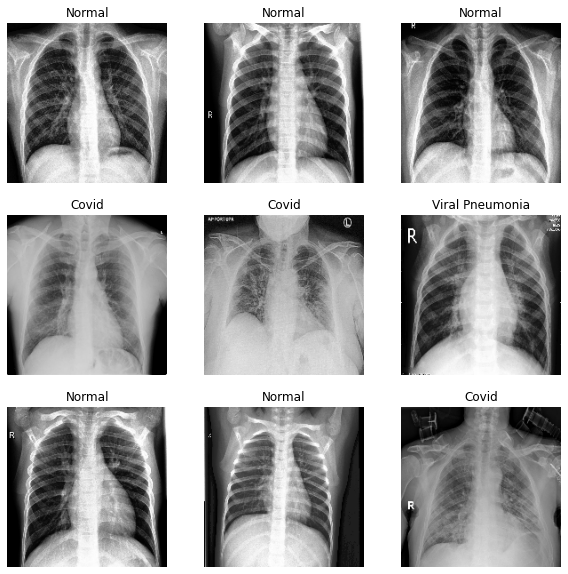

In [5]:
#Here's the first 9 Images from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Image Data Augmentation

In [6]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

### The images after random augmentation

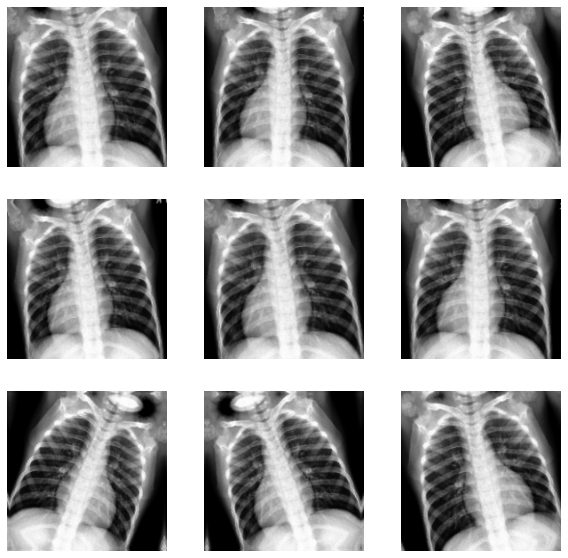

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Configure the dataset for performance

In [8]:
train_dataset = train_dataset.prefetch(buffer_size=32)
test_dataset = test_dataset.prefetch(buffer_size=32)

### Building the Model

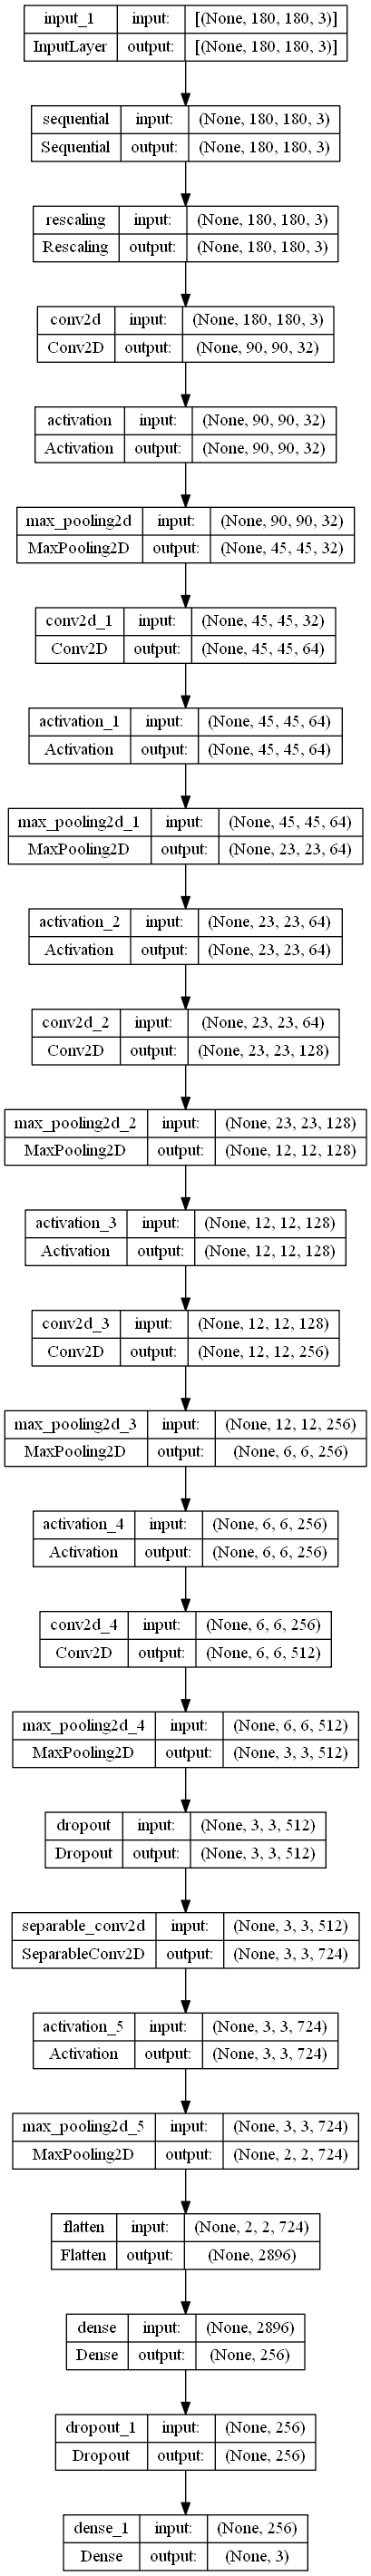

In [9]:
keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

### Defining the Callbacks

In [10]:
def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Training the Model

In [11]:
#Training the Models by using the epochs method
epochs = 50

model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

history = model.fit(
    train_dataset, epochs = epochs, 
    callbacks = [lr_callback],
    validation_data = test_dataset)

Epoch 1/50
7/7 [==============================] - 10s 326ms/step - loss: 1.2356 - accuracy: 0.3900 - val_loss: 1.0982 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - 2s 191ms/step - loss: 1.0973 - accuracy: 0.3950 - val_loss: 1.0962 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 3/50
7/7 [==============================] - 3s 218ms/step - loss: 1.0939 - accuracy: 0.4450 - val_loss: 1.0932 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 4/50
7/7 [==============================] - 3s 224ms/step - loss: 1.0903 - accuracy: 0.4200 - val_loss: 1.0865 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 5/50
7/7 [==============================] - 3s 232ms/step - loss: 1.0855 - accuracy: 0.4550 - val_loss: 1.0846 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 6/50
7/7 [==============================] - 2s 207ms/step - loss: 1.0779 - accuracy: 0.4450 - val_loss: 1.0936 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 7/50
7/7 [==============================] - 3s 220ms/step - loss: 1.0758 - 

### Plotting the Accuracy

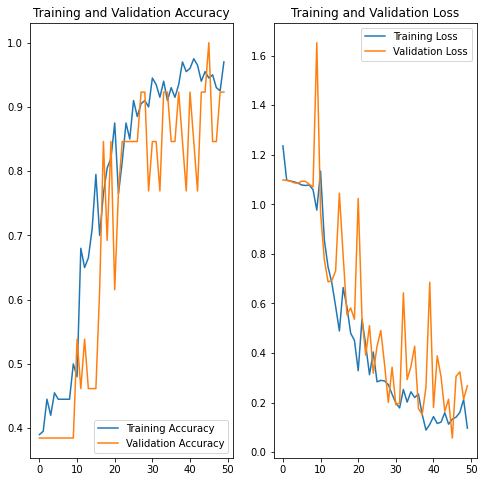

In [12]:
#Plotting the accuracies by using the plot
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Identifying the Outcome

In [15]:
#Identifying the image whether it is Normal, Covid or Viral Pneumonia 
image_path1 = "C:/Users/charl/Downloads/Covid 19 Dataset/validation/pic1.jpeg"
image_path2 = "C:/Users/charl/Downloads/Covid 19 Dataset/validation/pic2.jpeg"
image_path3 = "C:/Users/charl/Downloads/Covid 19 Dataset/validation/pic3.jpeg"
image_path4 = "C:/Users/charl/Downloads/Covid 19 Dataset/validation/pic4.jpeg"
image_path5 = "C:/Users/charl/Downloads/Covid 19 Dataset/validation/pic5.jpeg"
image_path6 = "C:/Users/charl/Downloads/Covid 19 Dataset/validation/pic6.jpeg"
image_path7 = "C:/Users/charl/Downloads/Covid 19 Dataset/validation/pic7.jpg"
image_path8 = "C:/Users/charl/Downloads/Covid 19 Dataset/validation/pic8.jpeg"
image_path9 = "C:/Users/charl/Downloads/Covid 19 Dataset/validation/pic9.jpeg"
image_path10 = "C:/Users/charl/Downloads/Covid 19 Dataset/validation/pic10.jpeg"
merged_path = [image_path1,image_path2,image_path3,image_path4,image_path5,image_path6,image_path7,image_path8,image_path9,image_path10]

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {}."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 20ms/step
This image most likely belongs to Normal.
1/1 [==============================] - 0s 19ms/step
This image most likely belongs to Covid.
1/1 [==============================] - 0s 19ms/step
This image most likely belongs to Viral Pneumonia.
1/1 [==============================] - 0s 17ms/step
This image most likely belongs to Viral Pneumonia.
1/1 [==============================] - 0s 19ms/step
This image most likely belongs to Normal.
1/1 [==============================] - 0s 21ms/step
This image most likely belongs to Covid.
1/1 [==============================] - 0s 20ms/step
This image most likely belongs to Covid.
1/1 [==============================] - 0s 20ms/step
This image most likely belongs to Viral Pneumonia.
1/1 [==============================] - 0s 23ms/step
This image most likely belongs to Covid.
1/1 [==============================] - 0s 18ms/step
This image most likely belongs to Normal.
